# Model Training and Feature Selection
Here we load the data preprocessed and the model parameters generated in the **preprocessing notebook**

In [43]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap

import xgboost as xgb
from sklearn.metrics import accuracy_score

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.provider import InlineProvider
from interpret import set_visualize_provider
from interpret.perf import ROC

In [44]:
def new_evaluate(model, X, y):
    proba_preds = model.predict_proba(X)[:,1]
    preds = model.predict(X)
    pred_labels = np.rint(preds)

    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y, proba_preds)
    # calculate AUC
    roc_auc = metrics.auc(fpr, tpr)
    # calculate accuracy
    accuracy = metrics.accuracy_score(y, pred_labels)

    print(f"AUC={roc_auc:.3f}")
    print(f"Accuracy={accuracy:.3f}")
          
    #plot a confusion matrix
    cm = metrics.confusion_matrix(y, pred_labels)

    # plot a confusion matrix as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns
    # label axes as "predicted and "actual"
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')#, center=0, linewidths=0.5)
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

    # print the classification report
    print(metrics.classification_report(y, pred_labels))

    # plot the ROC curve
    # label axes
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #add grid
    plt.grid(True)
    # plot the ROC curve
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    # plot the 45 degree line
    plt.plot([0,1], [0,1], 'k--', label="Random")
    # add a legend
    plt.legend()
    # show the plot
    #plt.show()


In [45]:
### Load preprocessed data

train_df = pd.read_csv('preprocessed/train.csv')
val_df = pd.read_csv('preprocessed/val.csv')
cal_df = pd.read_csv('preprocessed/cal.csv')
test_df = pd.read_csv('preprocessed/test.csv')

# Load predictor_list
with open('preprocessed/predictor_list.json', 'r') as f:
    predictor_list = json.load(f)

### Model Training
Based on the parameters obtained by the Optuna Study 

In [46]:
# Load the best parameters from the JSON file
with open("best_params.json", "r") as f:
    best_params = json.load(f)

print("Loaded best parameters:")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Loaded best parameters:
    classifier: XGBoost
    xgb_colsample_bytree: 0.7896000122582489
    xgb_learning_rate: 0.027434724266888824
    xgb_max_depth: 8
    xgb_n_estimators: 211
    xgb_subsample: 0.7188066640151899


In [47]:
%%time

# Set the parameters for the best XGBoost model
param = {
    "objective": "binary:logistic",
    "colsample_bytree": best_params["xgb_colsample_bytree"],
    "learning_rate": best_params["xgb_learning_rate"],
    "max_depth": best_params["xgb_max_depth"],
    "n_estimators": best_params["xgb_n_estimators"],
    "subsample": best_params["xgb_subsample"],
    "early_stopping_rounds": 100,
}

# Initialize the XGBoost model with the best parameters
gbm = xgb.XGBClassifier(**param)

# Train the model on the entire training set
gbm.fit(train_df[predictor_list], train_df['Status'], eval_set=[(train_df[predictor_list], train_df['Status'])], verbose=False)

# Evaluate the model on the validation set
preds = gbm.predict(val_df[predictor_list].values)
pred_labels = np.rint(preds).astype(int)
accuracy = accuracy_score(val_df['Status'].values.astype(int), pred_labels)
print(f"XGBoost model accuracy={accuracy:0.3f}")

XGBoost model accuracy=0.699
CPU times: user 3.28 s, sys: 1.01 s, total: 4.28 s
Wall time: 1.59 s


GBM
AUC=0.772
Accuracy=0.699


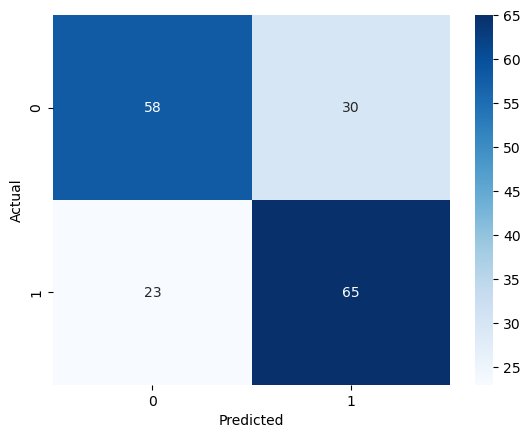

              precision    recall  f1-score   support

           0       0.72      0.66      0.69        88
           1       0.68      0.74      0.71        88

    accuracy                           0.70       176
   macro avg       0.70      0.70      0.70       176
weighted avg       0.70      0.70      0.70       176



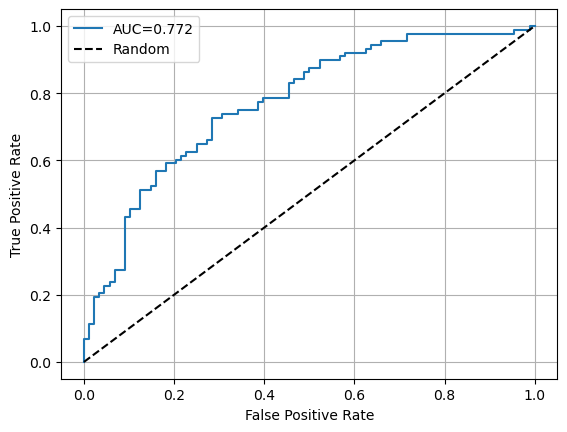

In [48]:
print("GBM")
new_evaluate(gbm, val_df[predictor_list].values, val_df['Status'].values)

## SHAP
SHAP (SHapley Additive exPlanations) values are a method to explain the output of machine learning models. SHAP values quantify the contribution of each feature to the final prediction made by the model. They tell us how much a given feature has pushed the prediction away from the average prediction.

#### How SHAP Values are Calculated

**Model Prediction**: Consider the prediction \( f(x) \) for a particular instance \( x \).

**Baseline Prediction**: This is the average prediction across all instances in the dataset, often denoted as \( f_0 \).

**Contribution**: The SHAP value for a feature \( i \), denoted as \( \phi_i \), represents the contribution of feature \( i \) to the difference between the model’s prediction for instance \( x \) and the baseline prediction.

**Summation**: The prediction can be expressed as:

$$
f(x) = f_0 + \sum_{i=1}^{n} \phi_i
$$

**Read**: https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

In [49]:
# Create an explainer object that can compute SHAP values for the model

explainer = shap.TreeExplainer(gbm)
shap_values = explainer(test_df[predictor_list])

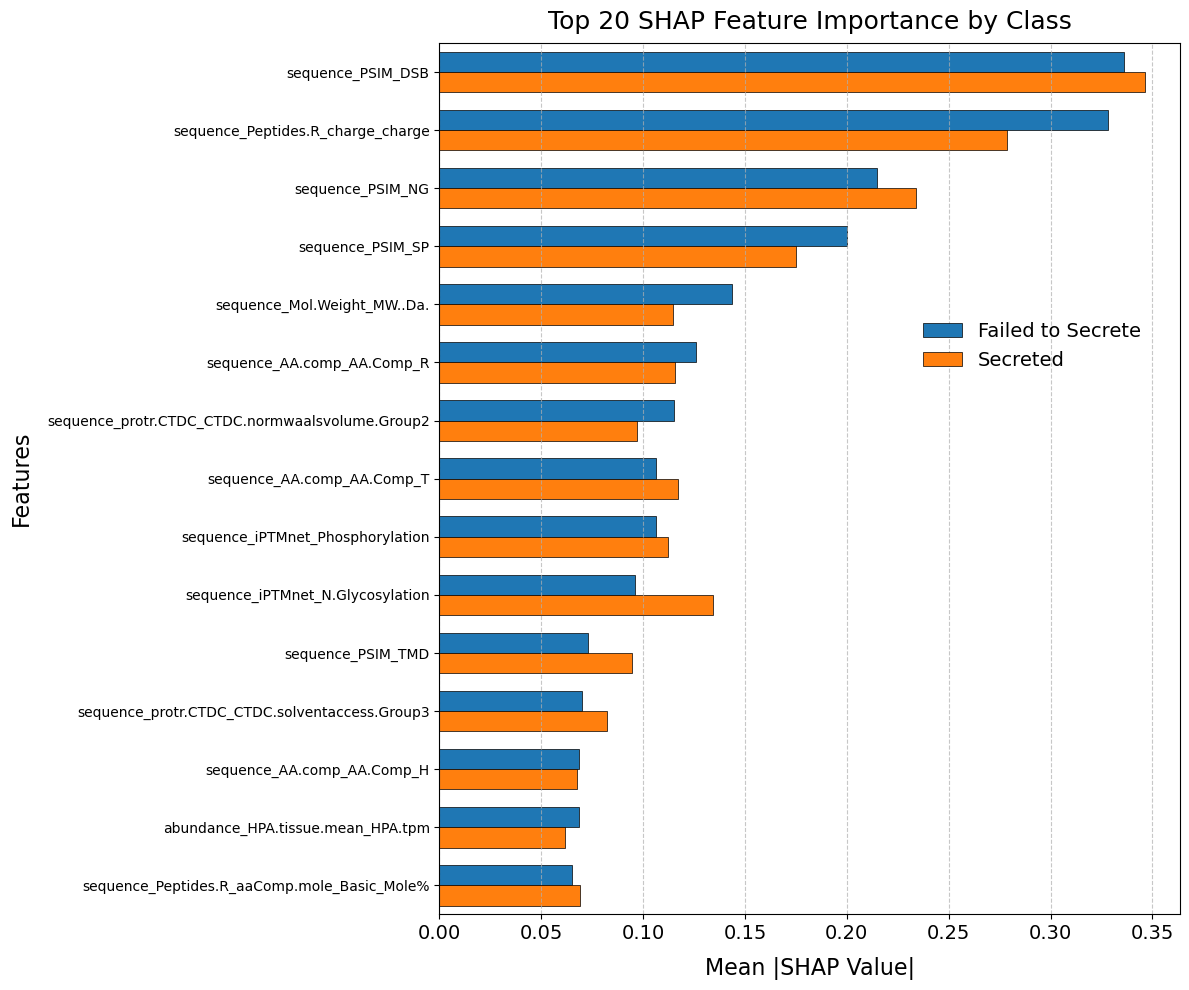

In [51]:
##################
# BAR PLOT
##################

# Step 1: Separate SHAP values by class
labels = test_df['Status']
shap_values_0 = shap_values.values[labels == 0]  # SHAP values for class 0
shap_values_1 = shap_values.values[labels == 1]  # SHAP values for class 1

# Step 2: Compute mean absolute SHAP values for each feature per class
features = test_df[predictor_list].columns
mean_shap_0 = np.abs(shap_values_0).mean(axis=0)
mean_shap_1 = np.abs(shap_values_1).mean(axis=0)

# Create a DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': features,
    'Class 0': mean_shap_0,
    'Class 1': mean_shap_1
}).sort_values(by=['Class 0', 'Class 1'], ascending=False)

# Select the top 20 features
shap_df = shap_df.head(15)

# Step 3: Create a horizontal grouped bar plot
plt.figure(figsize=(12, 10))
width = 0.35  # Bar width
y = np.arange(len(shap_df))  # Indices for the features

plt.barh(y - width / 2, shap_df['Class 0'], height=width, label='Failed to Secrete', color='#1f77b4', edgecolor='black', linewidth=0.5)
plt.barh(y + width / 2, shap_df['Class 1'], height=width, label='Secreted', color='#ff7f0e', edgecolor='black', linewidth=0.5)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.ylabel('Features', fontsize=16, labelpad=10)
plt.xlabel('Mean |SHAP Value|', fontsize=16, labelpad=10)
plt.title('Top 20 SHAP Feature Importance by Class', fontsize=18, pad=10)
plt.yticks(y, shap_df['Feature'], fontsize=10)
plt.xticks(fontsize=14)
plt.legend(fontsize=14, frameon=False, loc='upper center', bbox_to_anchor=(0.8, 0.7), ncol=1)

plt.ylim(-0.5, len(shap_df) - 0.5)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('results/shap_feature_importance.svg', format='svg', bbox_inches='tight') 
plt.show()

The summary plot shows the feature importance of each feature in the model. The results show that “DSB,” “Charge,”, “NG” and "SP" play major roles in determining the results.
- The length of each bar shows the mean absolute SHAP value for that feature. A longer bar means that feature, on average, has a greater impact (positive or negative) on the prediction.

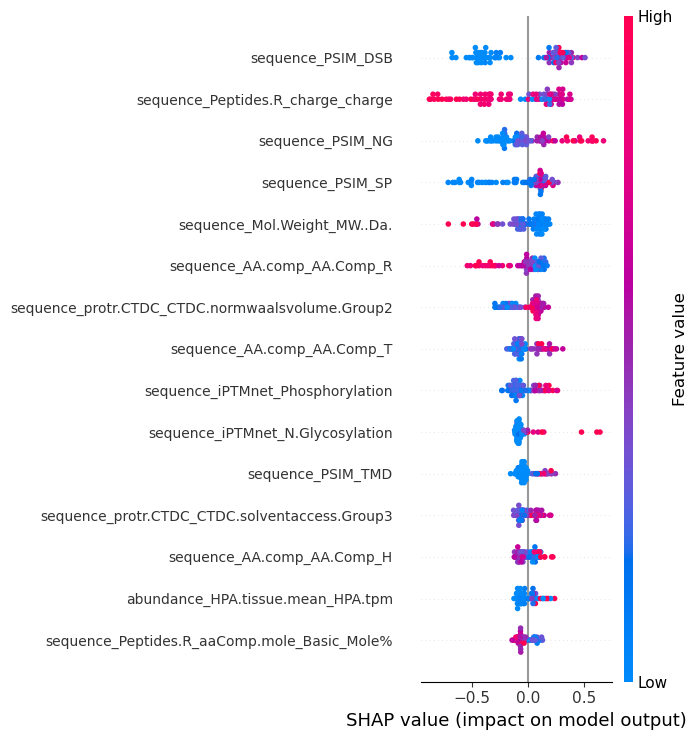

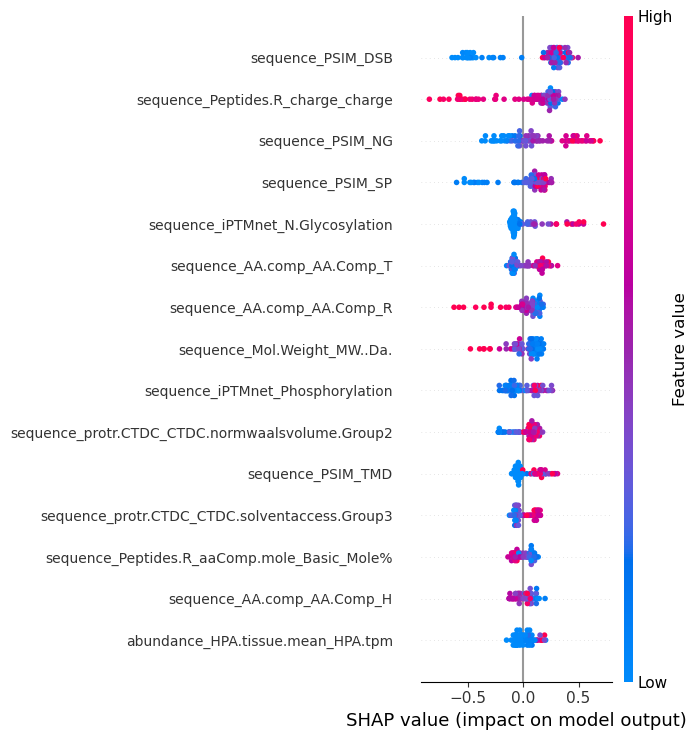

In [58]:
#########################
# SWARM PLOT
#########################

# Step 1: Filter SHAP values and test data for each class
shap_values_0 = shap_values.values[labels == 0]  # SHAP values for Class 0
shap_values_1 = shap_values.values[labels == 1]  # SHAP values for Class 1

test_df_0 = test_df[labels == 0]  # Data corresponding to Class 0
test_df_1 = test_df[labels == 1]  # Data corresponding to Class 1

# Step 2: Create a SHAP summary plot for Class 0
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_0, 
    test_df_0[predictor_list], 
    plot_type="dot", 
    show=False, 
    max_display=15
)

plt.yticks(fontsize=10)
plt.gca().tick_params(axis='y', pad=0)
plt.savefig('results/shap_swarmplot_class_0.svg', format='svg', bbox_inches='tight')
plt.show()

# Step 3: Create a SHAP summary plot for Class 1
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_1, 
    test_df_1[predictor_list], 
    plot_type="dot", 
    show=False, 
    max_display=15
)
plt.yticks(fontsize=10)
plt.gca().tick_params(axis='y', pad=0)
plt.savefig('results/shap_swarmplot_class_1.svg', format='svg', bbox_inches='tight')
plt.show()

Each point represents a SHAP value for a single prediction in the dataset.
- Typically, the color represents the feature value (e.g., red for high values and blue for low values). This helps understand how the feature's value affects its contribution.
- The horizontal spread of points shows the range of SHAP values for that feature, indicating how much the feature's impact varies across different predictions.
- Positive SHAP Values: Indicate that the feature value increases the prediction.
- Negative SHAP Values: Indicate that the feature value decreases the prediction.

In this scenario (filtered to Status == 0), features with large negative SHAP values are those most strongly driving the model to say “fail.”

SHAP force plot provides an intuitive visualization of how individual features contribute to a specific prediction, in this case, for a "Fail" sample.
- Features with positive SHAP values push the prediction toward "Pass" (class 1). The length of the arrow indicates the magnitude of the contribution.
- Features with negative SHAP values push the prediction toward "Fail" (class 0). The longer the arrow, the more that feature contributed to a lower model output.
- The final prediction is shown as the output value on the x-axis. If the final output is closer to the "Fail" side, the sample is classified as "Fail."

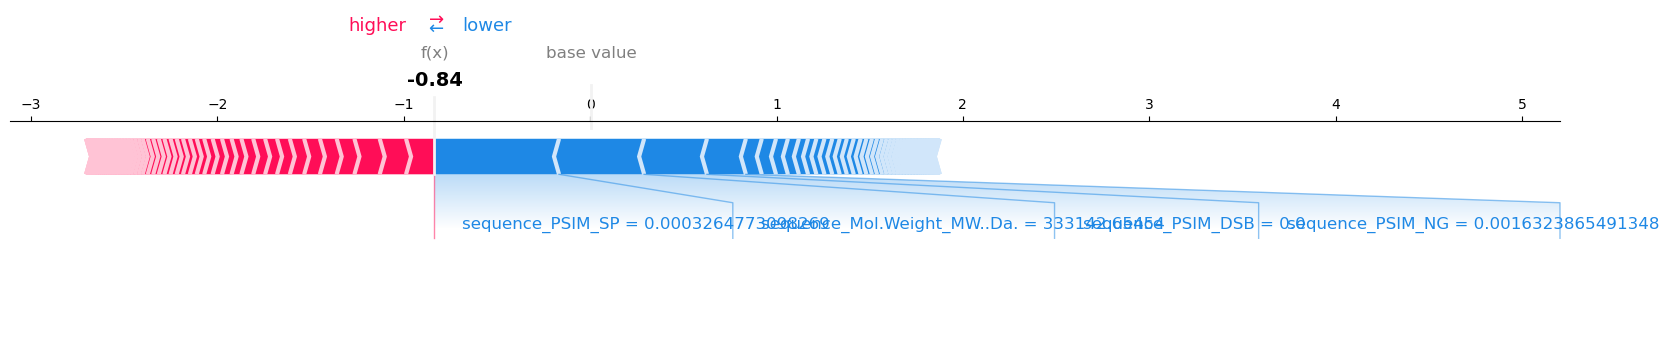

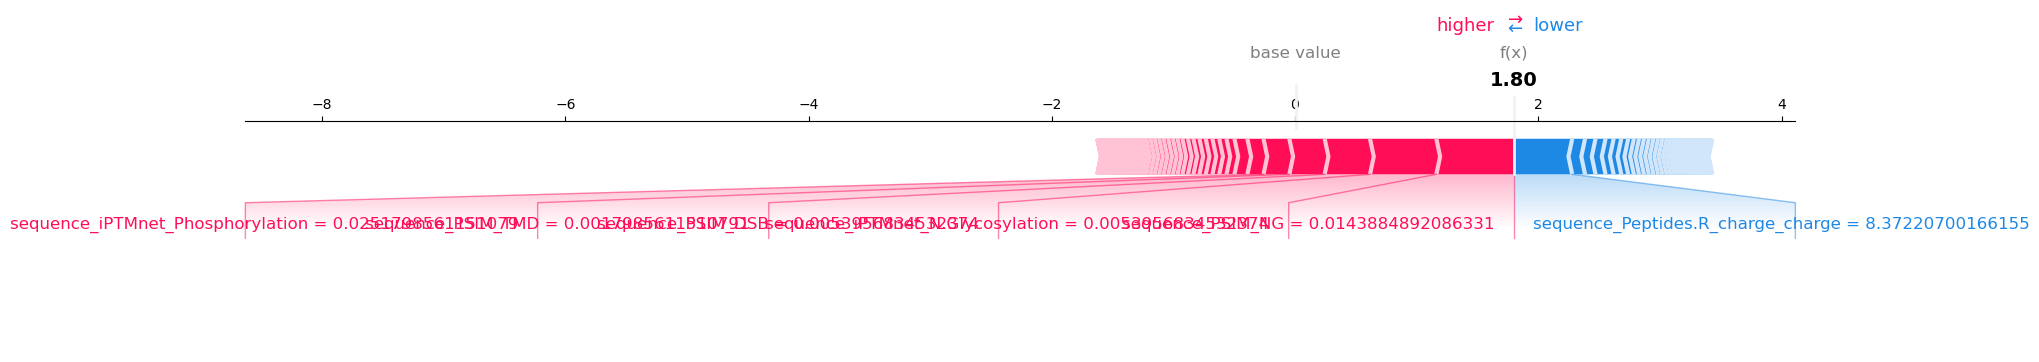

In [59]:
# Step 1: Identify a representative sample index for each class
# Example: Use the first occurrence of each class as a representative sample
sample_idx_0 = labels[labels == 0].index[20]  # First instance of Class 0
sample_idx_1 = labels[labels == 1].index[0]  # First instance of Class 1

# Step 2: Generate force plot for Class 0 representative sample
shap.force_plot(
    base_value=explainer.expected_value,            # The base value (average model output)
    shap_values=shap_values.values[sample_idx_0],   # SHAP values for this sample
    features=test_df[predictor_list].iloc[sample_idx_0],  # Feature values for this sample
    feature_names=predictor_list,
    matplotlib=True  # Render inline with matplotlib
)

# Step 3: Generate force plot for Class 1 representative sample
shap.force_plot(
    base_value=explainer.expected_value,            # The base value (average model output)
    shap_values=shap_values.values[sample_idx_1],   # SHAP values for this sample
    features=test_df[predictor_list].iloc[sample_idx_1],  # Feature values for this sample
    feature_names=predictor_list,
    matplotlib=True  # Render inline with matplotlib
)

- Base Value: This is the model’s expected output if you had no feature information (essentially the average log-odds or probability across the training data)
- Feature Contributions: Each feature “pushes” the model’s prediction away from the base value in either a positive (red) or negative (blue) direction.
- Red bars or arrows show features pushing the prediction toward a higher probability of class 1 (“produced”).
- Blue bars or arrows show features pushing the prediction toward a higher probability of class 0 (“failed”).

By summing all the positive and negative contributions with the base value, you arrive at the model’s final predicted log-odds for that sample (which translates to the probability of class 1 vs. class 0).

So, for a “failed” protein (Status=0), you might see that certain features have strong negative (blue) SHAP values, indicating they shifted the model’s prediction heavily toward failure.

In [62]:
test_df

,abundance_GTEx_Adipose,abundance_GTEx_Artery,abundance_GTEx_Brain,abundance_GTEx_Breast,abundance_GTEx_Cervix,abundance_GTEx_Colon,abundance_GTEx_Esophagus,abundance_GTEx_Heart,abundance_GTEx_Kidney,abundance_GTEx_Muscle,...,sequence_protr.CTDT_CTDT.prop5.Tr1221,sequence_protr.CTDT_CTDT.prop5.Tr1331,sequence_protr.CTDT_CTDT.prop5.Tr2332,sequence_protr.CTDT_CTDT.prop6.Tr1221,sequence_protr.CTDT_CTDT.prop6.Tr1331,sequence_protr.CTDT_CTDT.prop6.Tr2332,sequence_protr.CTDT_CTDT.prop7.Tr1221,sequence_protr.CTDT_CTDT.prop7.Tr1331,sequence_protr.CTDT_CTDT.prop7.Tr2332,Status
0,0.75345,0.727400,0.276093,7.7790,1.683500,5.69455,0.829567,0.209140,0.87590,0.03520,...,0.230159,0.007937,0.103175,0.230159,0.190476,0.095238,0.269841,0.174603,0.142857,0
1,0.46040,0.291033,0.613485,0.6093,0.641850,0.51295,0.424667,0.213750,0.43080,0.08264,...,0.145215,0.019802,0.161716,0.224422,0.199670,0.196370,0.265677,0.239274,0.179868,0
2,5.01500,0.985300,0.341531,3.2010,1.052000,1.18430,1.308100,3.544500,27.96000,0.28370,...,0.185586,0.016216,0.156757,0.259459,0.237838,0.158559,0.255856,0.227027,0.156757,1
3,0.15500,0.690067,0.948262,0.1748,0.198450,0.14020,0.119540,0.395120,0.18170,0.03997,...,0.207317,0.024390,0.170732,0.247967,0.264228,0.150407,0.272358,0.223577,0.170732,1
4,133.85000,74.230000,2.632223,112.3000,95.065000,27.78000,15.724000,44.070000,24.26000,9.56500,...,0.200000,0.031034,0.134483,0.196552,0.306897,0.141379,0.237931,0.217241,0.186207,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,6.19900,19.003333,2.015385,6.6630,10.476500,3.00700,5.836333,4.251000,3.39400,2.52500,...,0.181818,0.022727,0.168182,0.200000,0.236364,0.154545,0.254545,0.236364,0.150000,1
171,0.24890,0.210533,0.719700,0.3600,0.686050,0.27235,0.289067,0.210050,0.29280,0.03952,...,0.169173,0.015038,0.067669,0.259398,0.221805,0.146617,0.236842,0.244361,0.142857,0
172,13.66500,10.481000,2.433385,12.4900,13.303000,5.82050,7.363667,4.763500,8.14800,2.44700,...,0.130435,0.028986,0.188406,0.286232,0.184783,0.213768,0.199275,0.235507,0.188406,1
173,18.32000,8.450000,6.704308,11.5400,41.735000,8.32250,9.238000,4.960500,2.24900,1.37300,...,0.156545,0.043185,0.164642,0.179487,0.276653,0.144399,0.290148,0.221323,0.155196,1


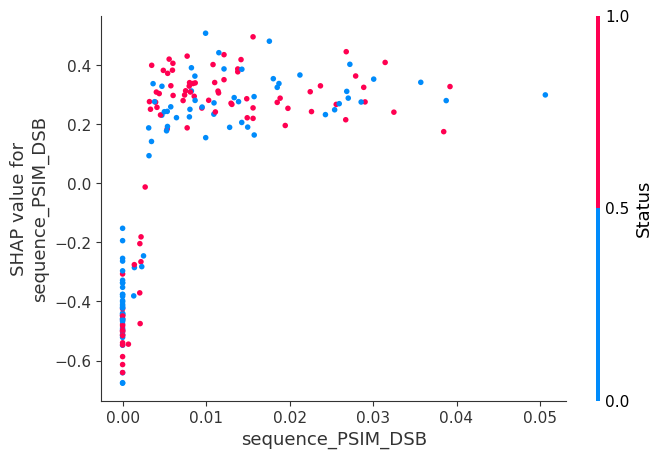

In [75]:
# Step 1: Add Status temporarily to the feature matrix
test_df_with_status = test_df[predictor_list].copy()
test_df_with_status['Status'] = test_df['Status']  # Add Status to the feature matrix

# Step 2: Add an extra column to SHAP values
# Create a column of zeros for the 'Status' feature
status_shap_column = np.zeros((shap_values.values.shape[0], 1))

# Append the new column to the SHAP values array
shap_values_with_status = np.hstack([shap_values.values, status_shap_column])

# Step 3: Dependence plot for a specific feature with the target variable as the color
feature_name = 'sequence_PSIM_DSB'  # Replace with your feature of interest

shap.dependence_plot(
    feature_name,
    shap_values_with_status,      # Modified SHAP values with the Status column
    test_df_with_status,          # Feature matrix including Status
    interaction_index='Status'    # Use Status for coloring
)

**Decision plot:** visualization that shows how each feature contributes to the model's prediction for individual instances. It helps in understanding the decision-making process of the model.
- Each line (trace) on the decision plot corresponds to one sample.
- The lines start from the base value on the left and wind through each feature’s contribution.
- Red segments indicate a positive SHAP value, meaning that feature pushed the prediction toward class 1.
- Blue segments indicate a negative SHAP value, meaning that feature pushed the prediction toward class 0.

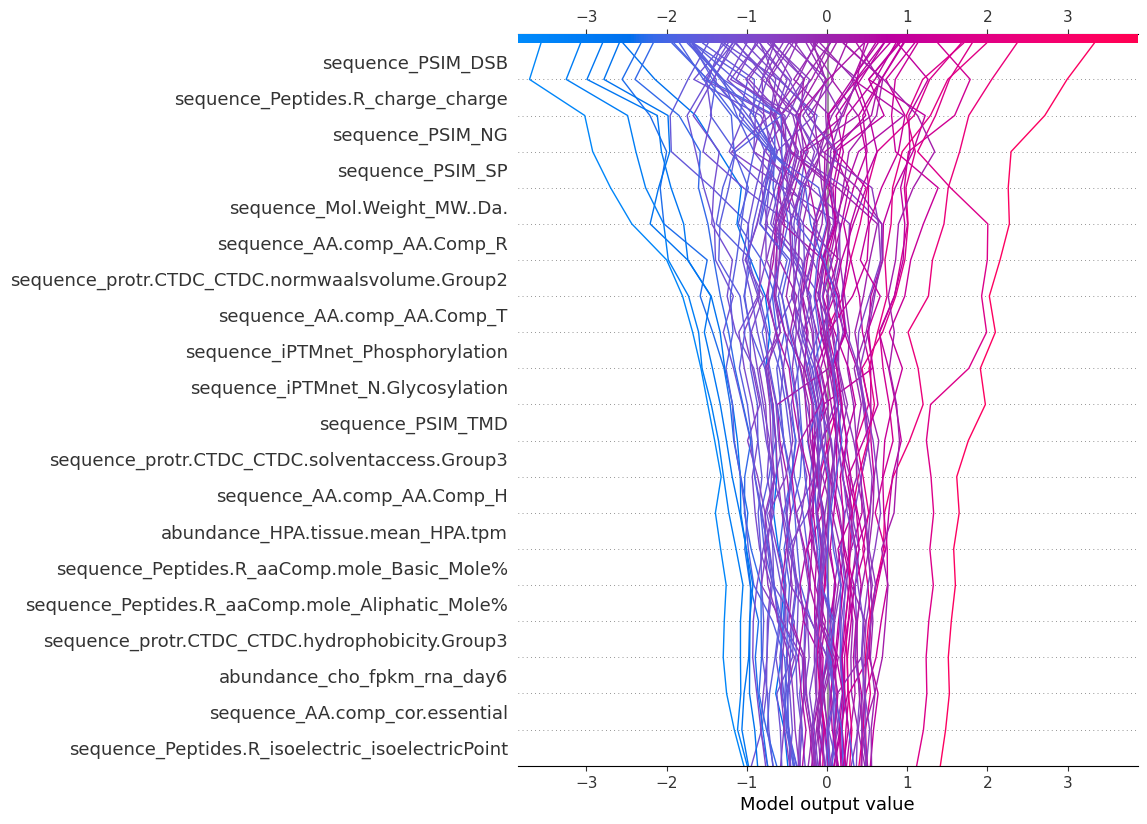

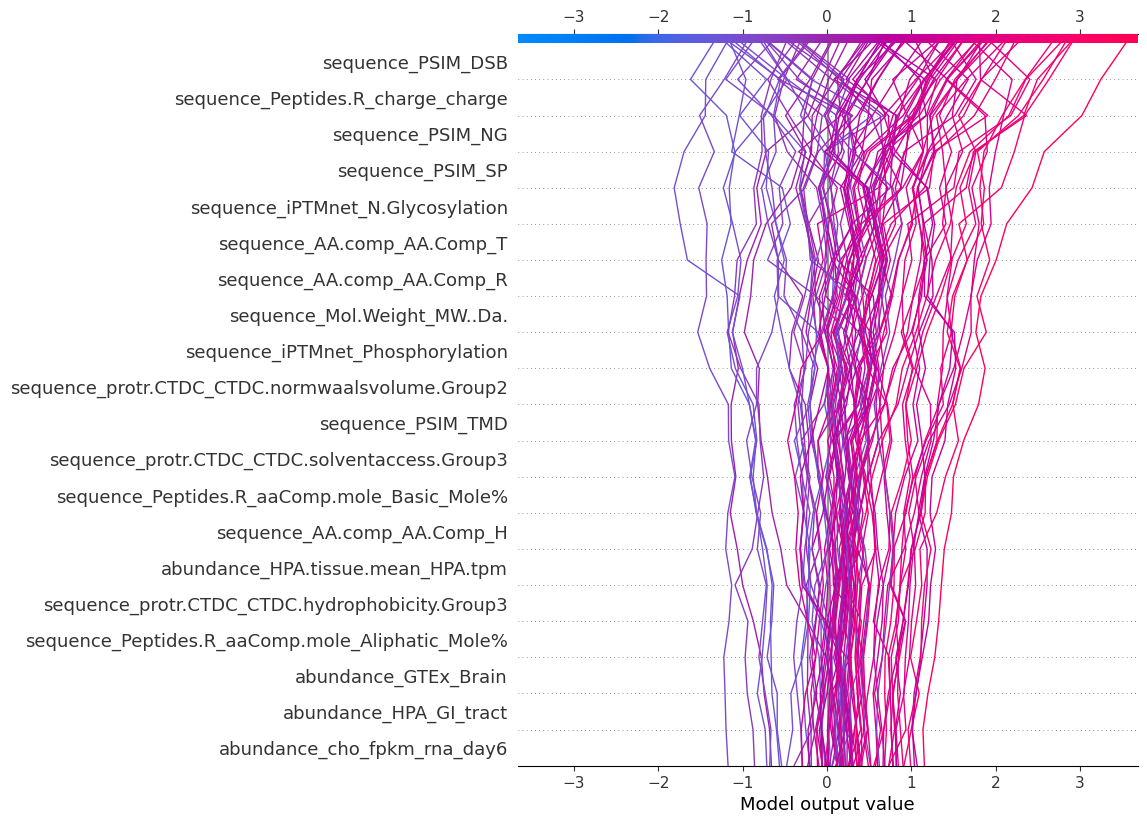

In [76]:
# Step 1: Filter SHAP values and test data for each class
shap_values_0 = shap_values.values[labels == 0]  # SHAP values for Class 0
shap_values_1 = shap_values.values[labels == 1]  # SHAP values for Class 1

test_df_0 = test_df[labels == 0][predictor_list]  # Features for Class 0
test_df_1 = test_df[labels == 1][predictor_list]  # Features for Class 1

# Step 2: Generate decision plot for all samples of Class 0
shap.decision_plot(
    base_value=explainer.expected_value,       # The base value (average model output)
    shap_values=shap_values_0,                 # SHAP values for all Class 0 samples
    feature_names=predictor_list,              # Feature names
    link='identity'                            # Direct scale for SHAP values
)

# Step 3: Generate decision plot for all samples of Class 1
shap.decision_plot(
    base_value=explainer.expected_value,       # The base value (average model output)
    shap_values=shap_values_1,                 # SHAP values for all Class 1 samples
    feature_names=predictor_list,              # Feature names
    link='identity'                            # Direct scale for SHAP values
)


In [ ]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(val_df[predictor_list].values), val_df[predictor_list], feature_names=predictor_list)

In [ ]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

## Train EBM
EBM is a type of Generalized Additive Model (GAM) that combines the strengths of machine learning models with the interpretability of linear models. It provides high predictive performance while maintaining transparency in how predictions are made.

In [ ]:
ebm = ExplainableBoostingClassifier()
ebm.fit(train_df[predictor_list], train_df['Status'])

In [ ]:
set_visualize_provider(InlineProvider())

In [ ]:
# create ebm_global with the top 40 features
ebm_global = ebm.explain_global(  )#name='EBM')
show(ebm_global)

In [ ]:
ebm_perf = ROC(ebm).explain_perf(val_df[predictor_list], val_df['Status'], name='EBM')
show(ebm_perf)

In [ ]:
print("EBM")
new_evaluate(ebm, val_df[predictor_list].values, val_df['Status'].values)